In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/ucsdpeds_vidf.zip' -d '/content/UCSDped1'

Streaming output truncated to the last 5000 lines.
  inflating: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f151.png  
  inflating: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f192.png  
 extracting: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f082.png  
  inflating: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f075.png  
  inflating: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f196.png  
 extracting: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f018.png  
 extracting: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f121.png  
 extracting: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f013.png  
  inflating: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f159.png  
 extracting: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f110.png  
 extracting: /content/UCSDped1/segm/vidf/vidf3_33_023.segm/vidf3_33_023_f081.png  
  inflating: /content/UCSDped1/segm/

In [ ]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
import cv2
import os

In [ ]:

import tensorflow
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

In [ ]:


imsize = 256


In [ ]:
def getClipByStride(frames , stride , sequenceSize=10):
    clips=[]
    clip=np.zeros(shape=(sequenceSize,imsize,imsize,1))
    cnt=0
    size=len(frames)
    start=0
    for i in range(start,size,stride):
        clip[cnt,:,:,0]=frames[i]
        cnt+=1
        if cnt==sequenceSize:
            clips.append(clip.copy())
            cnt=0
            if len(clips)==6:
                break
    return clips



In [ ]:
pwd

'/content'

In [ ]:
    anomaly_set=[3,5,6,9,12,13,14,16,19,20,25,28,31,34,36,40,41,42,45,49,51,57,60,61,62,67,72,85,86,95,97,100,108,114,120,119,121,128,139,138,140,155,160,166]
len(anomaly_set)

44

In [ ]:
def get_training_data():
    # pwd='C:\\Users\\abc\\deep learning\\staelstm anomaly detection'
    data_path='/content/UCSDped1/video/vidf'
    # join(pwd,"anomaly detection ped1","UCSDped1")
    anomaly_set=[3,5,6,9,12,13,14,16,19,20,25,28,31,34,36,40,41,42,45,49,51,57,60,61,62,67,72,85,86,95,97,100,108,114,120,119,121,128,139,138,140,155,160,166]
    anomaly_index=0
    clips=[]

    for vid_path in sorted(listdir(data_path)):
        if  not join(data_path,vid_path).endswith("y"):
            continue
        anomaly_index+=1
        if anomaly_index in anomaly_set:
            continue
        all_frames=[]
        count=0
        for img_path in sorted(listdir(join(data_path,vid_path))):

            if join(data_path,vid_path,img_path).endswith(("png")):

                image=Image.open(join(data_path,vid_path,img_path)).resize((imsize,imsize)).convert('L')
                image=np.array(image, dtype=np.float16)/float(255)

                all_frames.append(image.copy())

        # for  stride in range(1,3):
        stride=3
        clips.extend(getClipByStride(all_frames,stride,sequenceSize=10))
    return clips








pwd=os.getcwd()
image=Image.open(join(pwd,"anomaly detection ped1","UCSDped1","vidf1_33_000.y","vidf1_33_000_f001.png")).resize((imsize,imsize)).convert('L')
image=np.array(image, dtype=np.float32)/float(255)

print(image.shape)

clip=np.zeros(shape=(10,imsize,imsize,1))
print(clip.shape)
clip[0,:,:,0]=image
print(clip)

In [ ]:
training_data=get_training_data()
training_data=np.array(training_data)

In [ ]:
np.save('img_train_data.npy',training_data)

In [ ]:
training_data=np.load('img_train_data.npy')

In [ ]:
training_data=training_data.reshape(-1,10,imsize,imsize,1)

In [ ]:
training_data.shape


(716, 10, 256, 256, 1)

In [ ]:

def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    tensorflow.keras.backend.set_floatx('float32')
    # if not reload_model:
    #     return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    # training_set = get_training_data()
    # training_set = np.array(training_set)
    # training_set = training_set.reshape(-1,10,imsize,imsize,1)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))

    return seq

In [ ]:
seq=get_model(reload_model=False)
print(seq.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 64, 64, 128)   15616     
 ributed)                                                        
                                                                 
 layer_normalization (Layer  (None, 10, 64, 64, 128)   256       
 Normalization)                                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 32, 32, 64)    204864    
 stributed)                                                      
                                                                 
 layer_normalization_1 (Lay  (None, 10, 32, 32, 64)    128       
 erNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 32, 32, 64)    2

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data,test_data=train_test_split(training_data,test_size=0.3,)

In [ ]:
train_data=training_data[:200].copy()

In [ ]:
train_data.shape

(200, 10, 256, 256, 1)

In [ ]:
del training_data

In [ ]:
np.save('test_data.npy',test_data)

In [ ]:
del test_data

### training for first 60 epochs

In [ ]:
seq.compile(loss='mse', optimizer = Adam(learning_rate=1e-4, epsilon=1e-6))
#seq.compile(loss='mse')
training_history=seq.fit(train_data, train_data,
        batch_size=4, epochs=60,shuffle=False,verbose=1)
seq.save("model_60e_2b.h5")

Epoch 1/60
50/50 [==============================] - 134s 2s/step - loss: 0.0368
Epoch 2/60
50/50 [==============================] - 80s 2s/step - loss: 0.0118
Epoch 3/60
50/50 [==============================] - 80s 2s/step - loss: 0.0094
Epoch 4/60
50/50 [==============================] - 80s 2s/step - loss: 0.0080
Epoch 5/60
50/50 [==============================] - 80s 2s/step - loss: 0.0072
Epoch 6/60
50/50 [==============================] - 80s 2s/step - loss: 0.0072
Epoch 7/60
50/50 [==============================] - 80s 2s/step - loss: 0.0061
Epoch 8/60
50/50 [==============================] - 80s 2s/step - loss: 0.0054
Epoch 9/60
50/50 [==============================] - 80s 2s/step - loss: 0.0051
Epoch 10/60
50/50 [==============================] - 80s 2s/step - loss: 0.0046
Epoch 11/60
50/50 [==============================] - 79s 2s/step - loss: 0.0043
Epoch 12/60
50/50 [==============================] - 79s 2s/step - loss: 0.0040
Epoch 13/60
50/50 [=============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


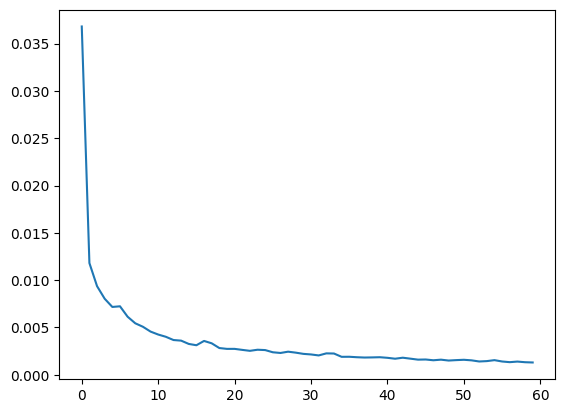

In [ ]:
plt.plot(training_history.history['loss'])
# plt.plot(training_history.history['val_loss'])



In [ ]:
training_history.params

{'verbose': 1, 'epochs': 60, 'steps': 50}

In [ ]:
training_history.history

{'loss': [0.036799561232328415,
  0.011804740875959396,
  0.009364571422338486,
  0.008035269565880299,
  0.007169119548052549,
  0.007239116821438074,
  0.006136651150882244,
  0.0054435692727565765,
  0.0050765578635036945,
  0.004567143507301807,
  0.004255264066159725,
  0.004018131643533707,
  0.003675340209156275,
  0.0036114188842475414,
  0.0032625379972159863,
  0.0031251467298716307,
  0.003578644711524248,
  0.0033282656222581863,
  0.0028288005851209164,
  0.0027396040968596935,
  0.002741054864600301,
  0.002633871743455529,
  0.0025340765714645386,
  0.002649981062859297,
  0.0026134562212973833,
  0.002381699625402689,
  0.002307546092197299,
  0.002444529440253973,
  0.002342089544981718,
  0.00221274490468204,
  0.0021520599257200956,
  0.002047888468950987,
  0.0022654589265584946,
  0.002250158693641424,
  0.0019005982903763652,
  0.0019071841379627585,
  0.0018582287011668086,
  0.00182574603240937,
  0.001838819356635213,
  0.0018589788815006614,
  0.00179574859794

### training for next 200 opochs


In [ ]:
from tensorflow.keras.callbacks import callbacks , ModelCheckpoints


ImportError: ignored

In [ ]:
del train_data

In [ ]:
test_data=np.load('test_data.npy')

In [ ]:
test_data.shape

(195, 10, 256, 256, 1)

In [ ]:
sequences=test_data[:3]

In [ ]:
sequences.shape

(3, 10, 256, 256, 1)

In [ ]:
del test_data


In [ ]:
fig = plt.figure(figsize=(8,8))
rows=3
columns=10
for i in range(3):

    for j in range(0,10):
        fig.add_subplot(rows,columns,i+1)
        plt.imshow(reconstructed_sequences[i][j])
plt.show()

3/3 [==============================] - 0s 175ms/step


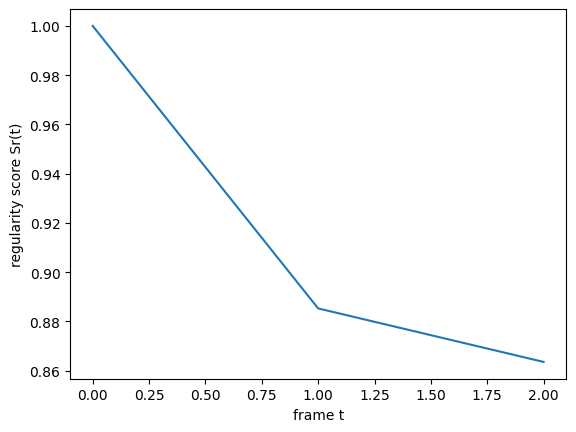

In [ ]:

reconstructed_sequences = seq.predict(sequences,batch_size=1)
# print(reconstructed_sequences)
#Sequences Reconstruction Cost e(x,y,sz)
sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,3)])
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
sr = 1.0 - sa

# plot the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

### testing first 12 videos

In [ ]:
model=load_model('/content/drive/MyDrive/model_30e_2b.h5')

In [ ]:
def getclipbystride(all_frames,stride,sequenceSize):

    clips=[]
    clip=np.zeros(shape=(10,imsize,imsize,1))
    cnt=0
    lenofframes=len(all_frames)
    for index in range(0,lenofframes,stride):
        clip[cnt,:,:,0]=all_frames[index]
        cnt+=1
        if cnt==sequenceSize:
            cnt=0
            clips.append(clip.copy())
    return clips

In [ ]:
def get_test_data():
    pwd=os.getcwd()
    data_path=join(pwd,"UCSDped1","video","vidf")
    clips=[]
    vidcnt=0
    for vid_path in sorted(listdir(data_path)):
        if  not join(data_path,vid_path).endswith('y'):
            continue
        all_frames=[]

        if vidcnt==15:
            break
        for img_path in sorted(listdir(join(data_path,vid_path))):
            if join(data_path,vid_path,img_path).endswith("png"):
                img=Image.open(join(data_path,vid_path,img_path)).resize((imsize,imsize)).convert('L')
                image=np.array(img,dtype=np.float32)/float(255)

                all_frames.append(image)
        clips.extend(getclipbystride(all_frames,4,sequenceSize=10))
        vidcnt+=1
    return clips



In [ ]:
test_data=get_test_data()
test_data=np.array(test_data)


In [ ]:
test_data.shape

(75, 10, 256, 256, 1)

In [ ]:
rows=5
columns=10
fig, axs = plt.subplots(rows,columns,figsize=(50,50))
for i in range(rows):
    for j in range(0,10):
        axs[i][j].imshow(test_data[i][j])
plt.show()

In [ ]:
test_data.shape

(75, 10, 256, 256, 1)

In [ ]:
test_data_matrix=test_data[10:20]#.reshape(-1,10,imsize,imsize,1)

In [ ]:
# test_data_matrix=test_data_matrix[:10]

In [ ]:
test_data_matrix.shape

(10, 10, 256, 256, 1)

In [ ]:
reconstructed_cost=[]
for i in range(10):
    reconstructed_cost.extend([np.linalg.norm(np.abs(np.subtract(reconstrcted_test_frame[i,j,:,:,0],test_data_matrix[i,j,:,:,0]))) for j in range(10)])
reconstructed_cost=np.array(reconstructed_cost)
sa = (reconstructed_cost - np.min(reconstructed_cost)) / np.max(reconstructed_cost)
sr = 1.0 - sa

# plot the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

NameError: ignored

In [ ]:
rows=10
columns=10
fig, axs = plt.subplots(rows*2,columns,figsize=(50,50))
for i in range(rows):

    for j in range(0,10):
        axs[i*2+1][j].imshow(reconstrcted_test_frame[i][j])

        axs[i*2][j].imshow(test_data_matrix[i][j])
plt.show()

### evaluation of model with first 15 video
### detection of anomalies

1/1 [==============================] - 0s 113ms/step


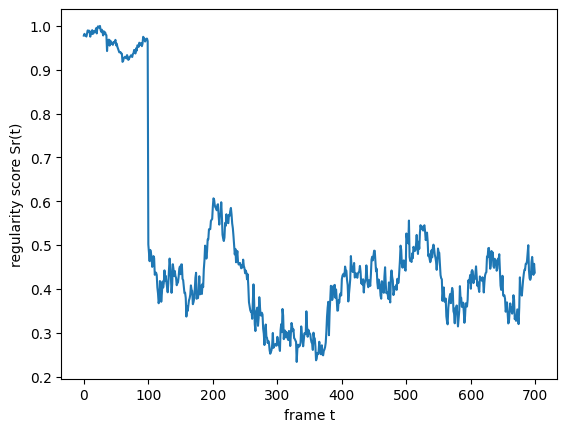

In [ ]:
reconstructed_cost=[]
for i in range(7):
    data_set_10_mat=test_data[i*10:i*10+10]
    reconstructed_images=model.predict(data_set_10_mat)
    for j in range(10):
        reconstructed_cost.extend([np.linalg.norm(np.abs(np.subtract(reconstructed_images[j,k,:,:,0],test_data[j,k,:,:,0]))) for k in range(10)])


reconstructed_cost=np.array(reconstructed_cost)
sa = (reconstructed_cost - np.min(reconstructed_cost)) / np.max(reconstructed_cost)
sr = 1.0 - sa

# plot the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [ ]:
model=load_model("/content/drive/MyDrive/unet dataset/weightimprovment_200.h5")

In [ ]:
del videofile

In [ ]:
pwd='/content/UCSDped1/video/vidf'
# pwd=os.path.join(pwd,"UCSDped1")
videofile=[]

no=0
for vid1_path in sorted(os.listdir(pwd)):
    if os.path.join(pwd,vid1_path).endswith("y"):

        # time.sleep(1)
        no+=1
        if no not in [47,48,49,50]:
            continue


        for frame in sorted(os.listdir(os.path.join(pwd,vid1_path))):



            frame_path=os.path.join(pwd,vid1_path,frame)
            if frame_path.endswith("png"):
                img=Image.open(frame_path).resize((imsize,imsize)).convert('L')
                image=np.array(img,dtype=np.float16)/float(255)
                videofile.append(image.copy())
count=0
clip=np.zeros(shape=(1,10,imsize,imsize,1))
clip=clip.astype(np.float16)
videofile
vf1000frames=[]
for i in range(len(videofile)-9):
    cnt=0
    for j in range(i ,i+10):
        clip[0,cnt,:,:,0]=videofile[j]
        cnt+=1
    vf1000frames.append(clip.copy())
vf1000frames=np.array(vf1000frames)
del videofile




In [ ]:
vf1000frames.shape

(791, 1, 10, 256, 256, 1)

In [ ]:
reconstructed_img=[]
for i in range(791):
    reconstructed_img.append(model.predict(vf1000frames[i]))
reconstructed_img=np.array(reconstructed_img)

1/1 [==============================] - 0s 84ms/step


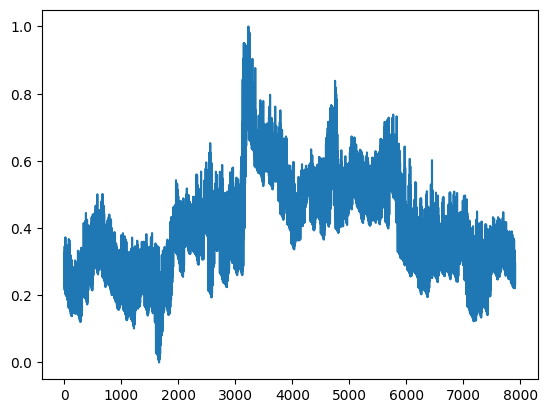

In [ ]:

psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)

In [ ]:
anomalycount=[]
for i in range(len(rs)):
  if rs[i] >0.7:
    anomalycount.append(i)
len(anomalycount)

195

In [ ]:
np.save('anomalycount.npy',np.array(anomalycount))

In [ ]:
rows=12
columns=10
fig, axs = plt.subplots(rows,columns,figsize=(50,50))
for i in range(rows):

    for j in range(0,10):
        ind=anomalycount[i*10+j]
        vfind=int(ind/10)
        frm=int(ind%10)
        axs[i][j].imshow(reconstructed_img[vfind][0][frm])

        # axs[i*2][j].imshow(test_data_matrix[i][j])
plt.show()

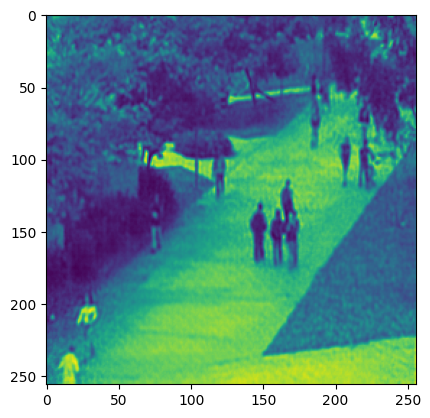

In [ ]:
ind=anomalycount[190]
vfind=int(ind/10)
frm=int(ind%10)
plt.imshow(reconstructed_img[vfind][0][frm])

### testing for 1 to 4 videos

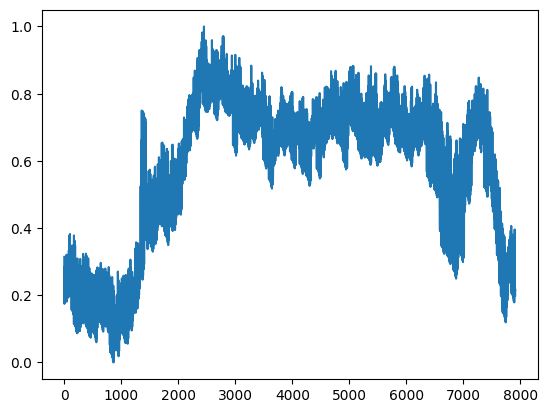

In [ ]:
psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)

### testing from vid 5 to 8

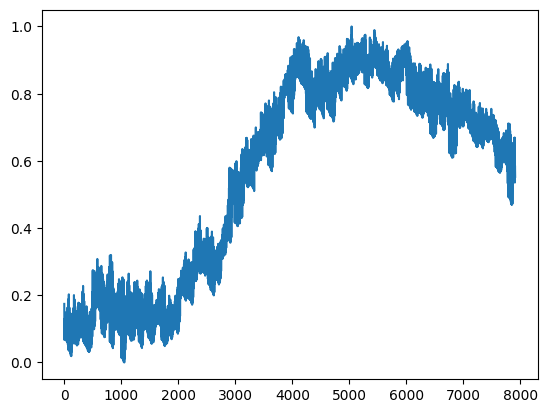

In [ ]:
psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)

###testing videos from 9to 12

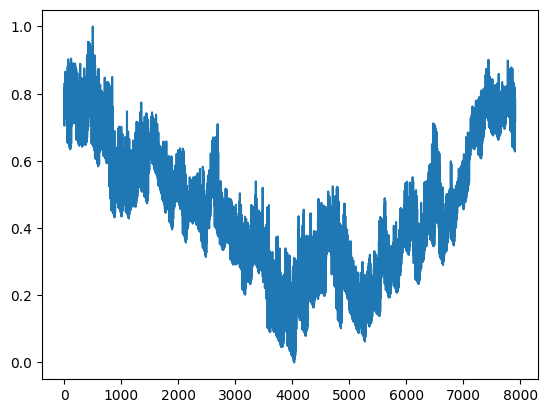

In [ ]:
psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)

### testing from 13 to 16

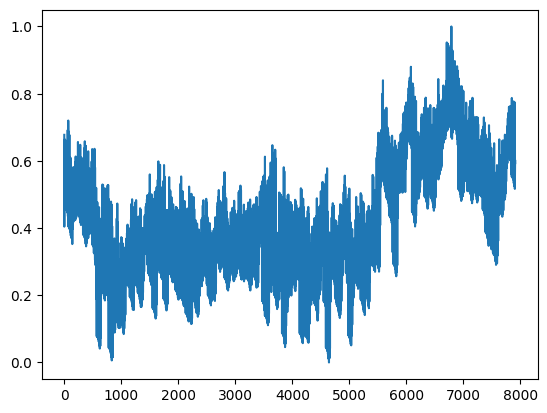

In [ ]:
psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)

### testing from 17 to 20

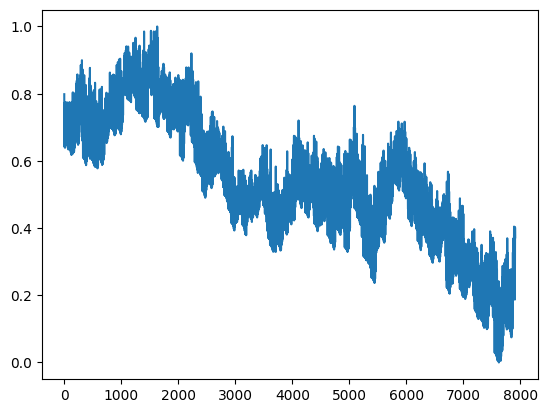

In [ ]:
psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)

### testing from 21 to 24

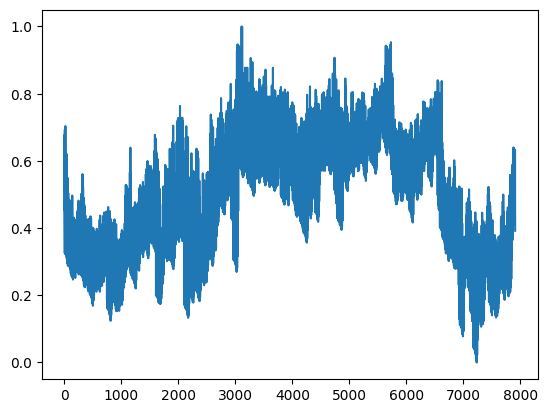

In [ ]:

psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)

### testing from 25 to 28

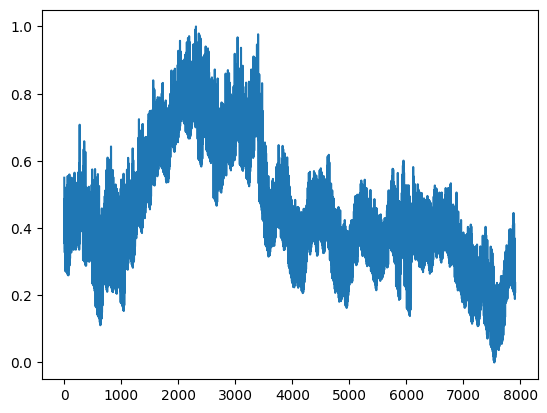

In [ ]:

psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)

### testing from 38 to 41

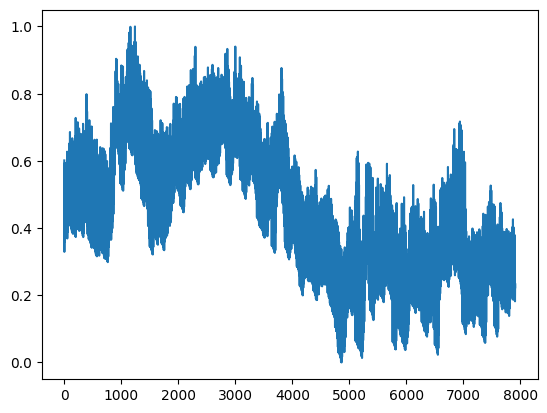

In [ ]:

psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)

#testing from 43 to 46

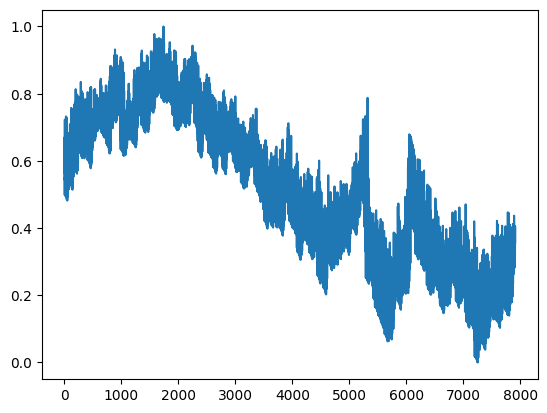

In [ ]:

psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)

### testing for 47 to 50

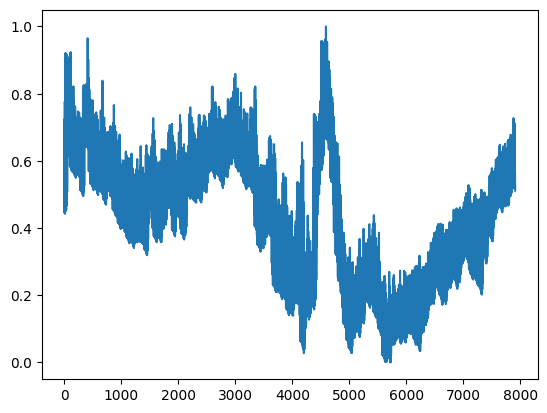

In [ ]:

psnr=[]
for reimg,orimg in zip(reconstructed_img,vf1000frames):
    for i in range(10):
        psnr.append(10*np.log10(np.square(np.max(reimg[0][i]))/(np.mean(np.square( np.subtract(reimg[0][i],orimg[0][i]) )))))

anos=(psnr-np.min(psnr))/(np.max(psnr)-np.min(psnr))

rs=1-anos
plt.plot(rs)